# Loading data with PyTorch
In this notebook we will investigate a few different ways to handle data with PyTorch on Alvis.

## Using your own data
In many cases you have a dataset in mind that you've already acquired and are keeping in your home folder or perhaps more probable in a storage project.

In this section we will use the dataset in `data.tar.gz`, first let us take a look at it.

### The file tree
To see what is contained in a tar file the command `tar -tf my_tarfile.tar` is useful. However, we might want to specifically know some things about the directory structure and filenames. This is done in the below script.

In [1]:
%%bash
# This will find the directories and files that do not have names ending with .png
# and then count the number of files with names containing ".png" for each of these
echo " #Files   Path"
echo "=================="
for dir in $(tar --exclude="*.png" -tf data.tar.gz); do
    n_files=$(tar -tf data.tar.gz --wildcards "$dir*.png" | wc -l)
    printf "  %5s   %s\n" "$n_files" "$dir"
done

# List the 5 first and last png filenames in /data/1/
echo  # New line
echo " Typical filenames"
echo "==================="
tar -tf data.tar.gz --wildcards --no-anchored "data/1/*.png" | (head -n 5; echo "..."; tail -n 5)

 #Files   Path
  60000   data/
   5923   data/1/
   5949   data/10/
   6742   data/2/
   5958   data/3/
   6131   data/4/
   5842   data/5/
   5421   data/6/
   5918   data/7/
   6265   data/8/
   5851   data/9/

 Typical filenames
data/1/im-00001.png
data/1/im-00021.png
data/1/im-00034.png
data/1/im-00037.png
data/1/im-00051.png
...
data/1/im-59940.png
data/1/im-59944.png
data/1/im-59952.png
data/1/im-59972.png
data/1/im-59987.png


***NOTE:*** For this tar file there where "only" 60000 files, for archives that are much larger these operations will mean a significant FileIO and should be avoided as much as possible. If there is a README in connection with the dataset it is wise to take a look at it.

### Looking at some of the data
Now we know the file structure of the data. Let us now get acquainted with the data a bit.

First extract a small subset of the images.

In [2]:
%%bash
# Extract the first 49 files
tar -xvf data.tar.gz --wildcards "data/*/im-000[0-4]?.png"

data/1/im-00001.png
data/1/im-00021.png
data/1/im-00034.png
data/1/im-00037.png
data/10/im-00004.png
data/10/im-00019.png
data/10/im-00022.png
data/10/im-00033.png
data/10/im-00043.png
data/10/im-00045.png
data/10/im-00048.png
data/2/im-00003.png
data/2/im-00006.png
data/2/im-00008.png
data/2/im-00014.png
data/2/im-00023.png
data/2/im-00024.png
data/2/im-00040.png
data/3/im-00005.png
data/3/im-00016.png
data/3/im-00025.png
data/3/im-00028.png
data/4/im-00007.png
data/4/im-00010.png
data/4/im-00012.png
data/4/im-00027.png
data/4/im-00030.png
data/4/im-00044.png
data/4/im-00049.png
data/5/im-00002.png
data/5/im-00009.png
data/5/im-00020.png
data/5/im-00026.png
data/6/im-00000.png
data/6/im-00011.png
data/6/im-00035.png
data/6/im-00047.png
data/7/im-00013.png
data/7/im-00018.png
data/7/im-00032.png
data/7/im-00036.png
data/7/im-00039.png
data/8/im-00015.png
data/8/im-00029.png
data/8/im-00038.png
data/8/im-00042.png
data/9/im-00017.png
data/9/im-00031.png
data/9/im-00041.png
data/9/im-000

Now let us take a look at these.

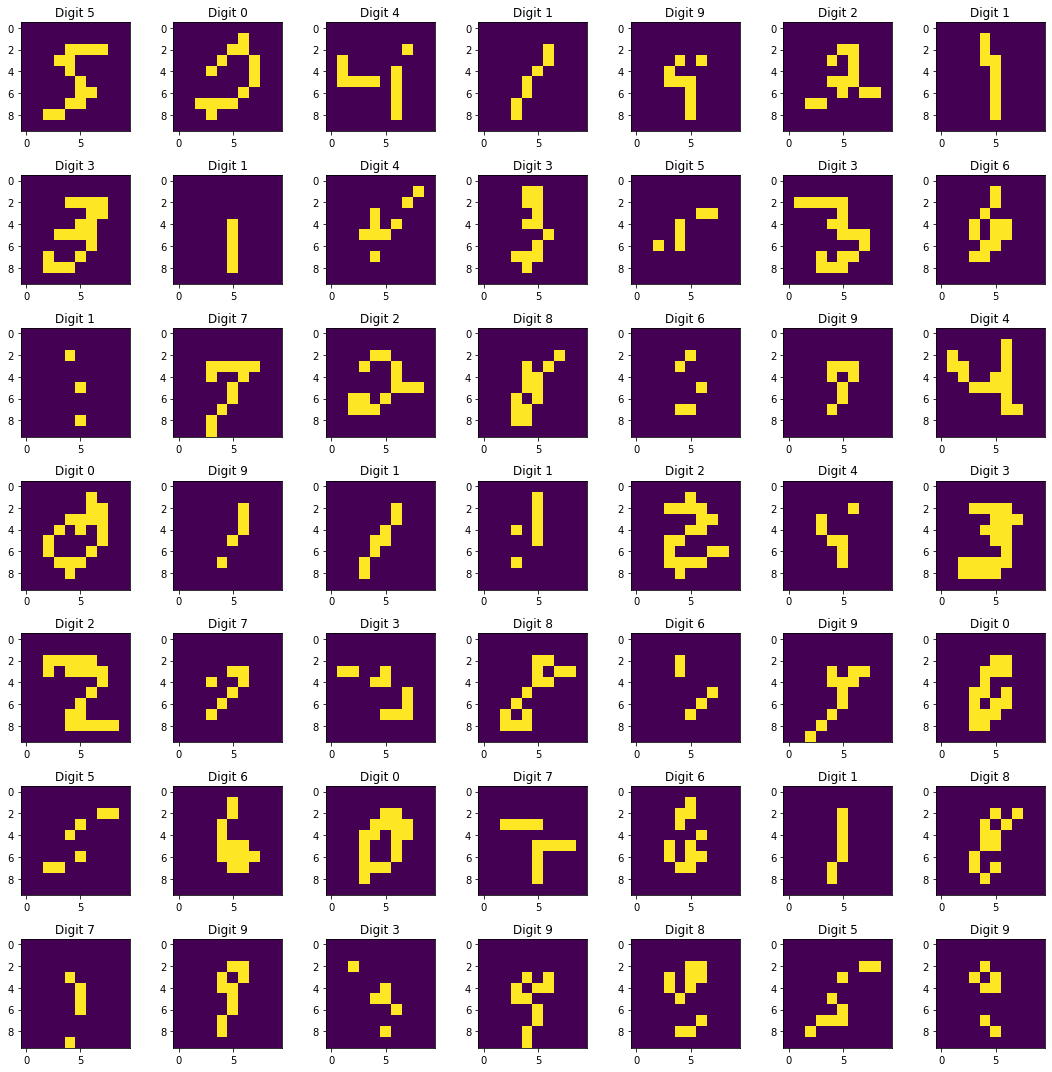

In [3]:
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

fig, ax_grid = plt.subplots(7, 7, figsize=(15, 15))
for ix, ax in enumerate(ax_grid.flatten()):
    # Get path to file and label
    filepath = glob(f"data/*/im-{ix:05d}.png")[0]
    _, label, filename = filepath.split("/")
    
    # Add to axis
    img = mpimg.imread(filepath)
    ax.imshow(img)
    ax.set_title(f"Digit {int(label) - 1}")

fig.tight_layout()

Note that the labels are offset by 1 compared to the digits. The dataset is actually a modified version of the MNIST handwritten digit training database. The images have been shrunk to only 9x9 pixels and monochrome images to reduce the size of the dataset.

### Training a classifier from this data
Now we have some understanding of what the database does and we are ready to do some ML on it.

First we will define our machine learning model.

In [4]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder

In [37]:
# 10 (3, 3) convolutional filters followed by a dense layer
model = nn.Sequential(
    nn.Conv2d(1, 10, 3),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(640, 10),
)

print(model)

opt = optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

Sequential(
  (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=640, out_features=10, bias=True)
)


Now we come to the step were we will load the data. When we have a dataset with the structure "root/class/input" then we can use `torchvision.dataset.DatasetFolder` or in the case of images `torchvision.dataset.ImageFolder`.

In [38]:
if len(glob("data/?/*.png")) < 60000:
    import warnings
    warnings.warn("\"data/\" is not fully unpacked!")
    
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
])
dataset = ImageFolder("data", transform=transform)
dataloader = DataLoader(
    dataset,
    batch_size=128,
    shuffle=True,
    num_workers=0,
)

<ipython-input-38-529f0fede7b6>:3: UserWarning: "data/" is not fully unpacked!
  warnings.warn("\"data/\" is not fully unpacked!")


In [35]:
# Training
def train(
    dataloader,
    model,
    opt,
    loss_func,
    n_epochs=3,
    device=torch.device("cuda:3"),
):
    model = model.to(device)
    model.train()
    
    for epoch in range(n_epochs):
        
        n_batches = len(dataloader)
        avg_loss = 0.0
        for x, label in dataloader:
            x, label = x.to(device), label.to(device)

            opt.zero_grad()

            logits = model(x)
            loss = loss_func(logits, label)
            
            avg_loss += loss.item()
            
            loss.backward()
            opt.step()
        
        avg_loss /= n_batches
        print(f"Loss: {avg_loss}")
            
    return model

In [36]:
train(dataloader, model, opt, loss_func)

RuntimeError: mat1 dim 1 must match mat2 dim 0

### Tasks
 1. Make yourself acquainted with the above code.
 2. Take a look at `jobscript-pytorch.sh` in this script we will unpack the dataset on \$TMPDIR and then train the model on the entire dataset

## Using available datasets
Some common public datasets are available at `/cephyr/NOBACKUP/Datasets`, if there are some specific dataset you would like to see added you can create a request at [SNIC-support](https://supr.snic.se/support/).

In this part we will access the processed MNIST dataset available at `/cephyr/NOBACKUP/Datasets/MNIST`

In [ ]:
from torchvision import datasets

In [ ]:
# 10 (3, 3) convolutional filters followed by a dense layer
model = nn.Sequential(
    nn.Conv2d(1, 10, 3),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(6760, 10),
)

print(model)

opt = optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

In this case it is really simple as this dataset has been processed for use with `torchvision.datasets.MNIST` and all we need to do is supply the correct path.

In [ ]:
dataset = datasets.MNIST("/cephyr/NOBACKUP/Datasets", transform=transforms.ToTensor())
dataloader = DataLoader(
    dataset,
    batch_size=128,
    shuffle=True,
    num_workers=0,
)

In [ ]:
train(dataloader, model, opt, loss_func)

## Loading data through the torchvision API
At `torchvision.datasets`, `torchaudio.datasets` and `torchtext.datasets` all have similar APIs that can be used to download datasets that do not exist in `/cephyr/NOBACKUP/Datasets`. However, note that this can take some time and you will have to store them yourself.

In [32]:
model = nn.Sequential(nn.Conv2d(1, 10, 3))
sum(p.numel() for p in model.parameters())
x = torch.randn(50, 1, 9, 9)
model(x).size()

torch.Size([50, 10, 7, 7])